In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, math
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import h5py
import pickle
import subprocess
import umap
import scipy
from csaps import csaps
import string
from joblib import dump, load
from datetime import date

In [2]:
######### Parameters of transitions between "macroscopic" states ##########
nstates_final = 7
n_components_tMat = 15
trajl = 40 # Trajectory Length for morphodynamical trajectory analysis

wellsInfo = 'Awells'
conditions = ['A2'] # LIGANDS (CONDITIONS)
tmSet = ['EGF1'] 
nConditions = len(tmSet) # Total number of Ligand Conditions
os.environ['OMP_NUM_THREADS'] = '1'; os.environ['MKL_NUM_THREADS'] = '1'

today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = sysName+'_tlen'+str(trajl)+'_'+date2day

# Indices for the ligands 
inds_tmSet = [i for i in range(nConditions)]
inds_tmSet = np.array(inds_tmSet).astype(int)
nfovs = 1
fovs = 1
dateSet = ['']
pathSet = ['/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/']
imagingSet = [0 for i in range(nConditions)]
modelList = [None]*(nfovs*(nConditions))
modelList_conditions = np.zeros(nfovs*(nConditions)).astype(int)

In [3]:
i = 0
icond = 0
for cond in conditions:
    modelList_conditions[i] = icond
    modelList[i] = pathSet[imagingSet[icond]]+sysName+'_'+cond+'_'+str(fovs)+dateSet[imagingSet[icond]]
    #print("Models: ",modelList[i])
    i = i + 1
    icond = icond + 1

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [4]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print('loaded '+objFile+' with '+str(modelSet[i].cells_indSet.size)+' cells')
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models,i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1.obj with 51054 cells


In [5]:
# Total number of frames (image snapshots) in one condition per FOVs
nframes = 193 
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*nframes/100.; sframe = math.ceil(sframe)
eframe = 98.5*nframes/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(nframes)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [6]:
#plt.clf()
#plt.figure(figsize = (8, 7))
with open('cellNumbers.dat', 'w', encoding = 'utf-8') as fp: # PRINT cell numbers in a file for each model
     for i in indgood_models:
        ncells = np.zeros(nframes)
        ncells_smooth = np.zeros_like(ncells)
        for iS in range(nframes):
           ncells[iS]=np.sum(modelSet[i].cells_frameSet==iS)
           fp.write(str(ncells[iS])+"\t")
           fp.write("\n")
        # Cubic Spline Approximation (CSAPS) to smoothen the data
        splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
        ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
        cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
        cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		
        #print("cellnumber_stdSet[",i,"] = ", cellnumber_std)
        #plt.plot(ncells/ncells[0], color = colModels[i], label = capModels[i])
        #plt.plot(ncells, color = colModels[i], label = capModels[i])
        #plt.plot(ncells/ncells[0]); plt.pause(.5)

In [32]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)

# get cell counts
num_ligand_conds = len(tmSet)
inds_tmSet_models = np.zeros(nmodels).astype(int)
inds_imagingSet_models = np.zeros(nmodels).astype(int)
i = 0
icond = 0
for cond in conditions:
    inds_tmSet_models[i] = inds_tmSet[icond]
    inds_imagingSet_models[i] = imagingSet[icond]
    i = i + 1
    icond = icond + 1

In [8]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0 #just replace with zeros for now? Not sure best...

In [9]:
nfeat_com = 3
Xf_com0 = np.zeros((0, nfeat_com))
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [10]:
wctm = cellTraj.Trajectory() # import Trajectory object 
nfeat = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, nfeat))
indtreatment = np.array([])
indcellSet = np.array([])
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
        # Indices for each model for later access using them
        indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
        indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [11]:
varCutOff = 10
from sklearn.decomposition import PCA #we will use the sklearn package (intended for ease of use over performance/scalability)
pca = PCA(n_components = varCutOff) #n_components specifies the number of principal components to extract from the covariance matrix
pca.fit(Xf) #builds the covariance matrix and "fits" the principal components
Xpca = pca.transform(Xf) #transforms the data into the pca representation
nPCs = Xpca.shape[1]

wctm.Xpca = Xpca
wctm.pca = pca
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        indsf = np.where(indtreatment == i)[0]
        modelSet[i].Xpca = Xpca[indsf, :]

indgood_models = indgood_models[np.where(inds_imagingSet_models[indgood_models] == 0)[0]]

In [12]:
self = wctm
wctm.trajl = trajl
all_trajSet = [None]*nmodels
for i in indgood_models:
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

tracked cell 50891, 25 tracks, 46600 left
tracked cell 50763, 23 tracks, 42400 left
tracked cell 50735, 51 tracks, 41500 left
tracked cell 50076, 1 tracks, 37700 left
tracked cell 49741, 1 tracks, 37600 left
tracked cell 49307, 1 tracks, 37500 left
tracked cell 49056, 18 tracks, 37400 left
tracked cell 48763, 1 tracks, 37100 left
tracked cell 48214, 1 tracks, 36900 left
tracked cell 48008, 1 tracks, 36800 left
tracked cell 47562, 1 tracks, 36500 left
tracked cell 46286, 1 tracks, 35900 left
tracked cell 46119, 3 tracks, 35700 left
tracked cell 45624, 1 tracks, 35600 left
tracked cell 42924, 7 tracks, 34200 left
tracked cell 41889, 2 tracks, 33800 left
tracked cell 41728, 1 tracks, 33700 left
tracked cell 40948, 1 tracks, 33300 left
tracked cell 39770, 1 tracks, 32900 left
tracked cell 39018, 1 tracks, 32500 left
tracked cell 38257, 1 tracks, 32300 left
tracked cell 38063, 6 tracks, 32200 left
tracked cell 37504, 1 tracks, 32000 left
tracked cell 35855, 2 tracks, 31300 left
tracked cell

In [13]:
# Single-cell trajectories over the dimensionally reduced features
Xpcat = np.zeros((0, pca.n_components_*trajl + nfeat_com*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
cellinds0_traj = np.array([])
cellinds1_traj = np.array([])
#cc_ratio_traj = np.array([])
cb_ratio_traj = np.array([])
for i in indgood_models:
    print('building trajectory data for model {}...'.format(i))
    modelSet[i].trajectories = all_trajSet[i].copy()
    modelSet[i].trajl = trajl
    modelSet[i].traj = modelSet[i].get_traj_segments(trajl)
    data = modelSet[i].Xpca[modelSet[i].traj, :] # Store Xpca along single-cell trajectory snippets
    datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xpca.shape[1]*trajl)
    datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0]
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :]
    Xpcat = np.append(Xpcat, data, axis = 0)
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0]))
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    indframes = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]]
    indframes_traj = np.append(indframes_traj, indframes)
    cellinds0 = modelSet[i].traj[:, 0]
    cellinds0_traj = np.append(cellinds0_traj, cellinds0)
    cellinds1 = modelSet[i].traj[:, -1]
    # cc_ratio = modelSet[i].cc_ratio[cellinds1]
    # cc_ratio_traj = np.append(cc_ratio_traj, cc_ratio)
    cellinds1_traj = np.append(cellinds1_traj, cellinds1)
    cb_ratio_traj = np.append(cb_ratio_traj, modelSet[i].Xf[cellinds1, 77])

cellinds0_traj = cellinds0_traj.astype(int)
cellinds1_traj = cellinds1_traj.astype(int)

building trajectory data for model 0...


In [14]:
#neigen = x.shape[1]
neigen = Xpcat.shape[1] # If embedded trajectories aren't UMAP'ed 
inds_conditions = [None]*nf
for imf in range(nf):
    indmodels = np.intersect1d(indgood_models, np.where(inds_tmSet_models == imf)[0])
    indstm = np.array([])
    for imodel in indmodels:
        indtm = np.where(indtreatment_traj == imodel)
        indstm = np.append(indstm, indtm)
    inds_conditions[imf] = indstm.astype(int).copy()

In [38]:
##### Cluster single-cell trajectories of a given snippet length by using KMeans from deeptime 
from deeptime.clustering import KMeans
n_clusters = 196
model = KMeans(n_clusters = n_clusters,  # place 100 cluster centers
               init_strategy = 'kmeans++',  # kmeans++ initialization strategy
               max_iter = 0,  # don't actually perform the optimization, just place centers
               fixed_seed = 13)
################################ Initial clustering ###############################
clustering = model.fit(Xpcat).fetch_model() # If embedded trajectories aren't UMAP'ed 
#clustering = model.fit(x).fetch_model()

model.initial_centers = clustering.cluster_centers
model.max_iter = 5000
clusters = model.fit(Xpcat).fetch_model() # If embedded trajectories aren't UMAP'ed 
#clusters = model.fit(x).fetch_model()
wctm.clusterst = clusters

In [39]:
knn = 50
for i in indgood_models:
    modelSet[i].trajectories = all_trajSet[i].copy()

In [40]:
def get_trajectory_steps(self, inds=None, traj=None, Xtraj=None,
                         get_trajectories=True, nlag=1): #traj and Xtraj should be indexed same
    if inds is None:
        inds = np.arange(self.cells_indSet.size).astype(int)
    if get_trajectories:
        self.get_unique_trajectories(cell_inds=inds)
    if traj is None:
        traj = self.traj
    if Xtraj is None:
        x = self.Xtraj
    else:
        x = Xtraj
    trajp1 = self.get_traj_segments(self.trajl + nlag)
    # Reversed index array inds_nlag is created to keep indices every nlag steps
    inds_nlag = np.flipud(np.arange(self.trajl + nlag - 1, -1, -nlag)).astype(int) #keep indices every nlag
    trajp1 = trajp1[:, inds_nlag]
    ntraj = trajp1.shape[0]
    #neigen = x.shape[1]
    neigen = Xpcat.shape[1]
    x0 = np.zeros((0, neigen))
    x1 = np.zeros((0, neigen))
    inds_trajp1 = np.zeros((0, 2)).astype(int)
    # Matching segments of trajectories and then appending the corresponding feature data from Xpcat to two arrays, 'x0' and 'x1'
    for itraj in range(ntraj):
        test0 = trajp1[itraj, 0:-1]
        test1 = trajp1[itraj, 1:]
        # traj[:, None] == test0[np.newaxis, :]: This expression compares each segment in 'traj' with 'test0'.
        # The use of [:, None] and [np.newaxis, :] reshapes the arrays for broadcasting, allowing element-wise
        # comparison between each segment in 'traj' and the segment 'test0'. 
        # .all(-1): This checks if all elements in a segment are equal, resulting in a boolean array where each
        # element represents whether a segment in 'traj' matches 'test0'.
        # .any(-1): This determines if there is any match in 'traj' for 'test0'. 'res0' is a boolean array indicating
        # which trajectories in 'traj' match 'test0'
        res0 = (traj[:, None] == test0[np.newaxis, :]).all(-1).any(-1)
        res1 = (traj[:, None] == test1[np.newaxis, :]).all(-1).any(-1)
        if np.sum(res0) == 1 and np.sum(res1) == 1:
            indt0 = np.where(res0)[0][0]
            indt1 = np.where(res1)[0][0]
            #x0 = np.append(x0, np.array([x[indt0, :]]), axis=0)
            #x1 = np.append(x1, np.array([x[indt1, :]]), axis=0)
            x0 = np.append(x0, np.array([Xpcat[indt0, :]]), axis=0)
            x1 = np.append(x1, np.array([Xpcat[indt1, :]]), axis=0)
            inds_trajp1 = np.append(inds_trajp1, np.array([[indt0, indt1]]), axis=0)
        if itraj%100 == 0:
            sys.stdout.write('matching up trajectory '+str(itraj)+'\n')
    self.Xtraj0 = x0
    self.Xtraj1 = x1
    self.inds_trajp1 = inds_trajp1

In [41]:
dxs = np.zeros((nmodels, n_clusters, neigen))
x0set = np.zeros((0, neigen))
x1set = np.zeros((0, neigen))
inds_trajsteps_models = np.array([]).astype(int)
for i in indgood_models:
    print('getting flows from model: '+str(i))
    indstm = np.where(indtreatment_traj == i)[0]
    if indstm.size > 0:
        #modelSet[i].Xtraj = x[indstm, 0:neigen]
        modelSet[i].Xtraj = Xpcat[indstm, 0:neigen]
        indstm_model = indstm - np.min(indstm) #index in model
        if inds_imagingSet_models[i] == 1:
            modelSet[i].get_trajectory_steps(inds=None, get_trajectories=False, traj=modelSet[i].traj[indstm_model, :],
                                             Xtraj=modelSet[i].Xtraj[indstm_model, :])
        else:
            get_trajectory_steps(modelSet[i], inds=None, get_trajectories=False, traj=modelSet[i].traj[indstm_model, :], 
                                 Xtraj=modelSet[i].Xtraj[indstm_model, :])
        x0 = modelSet[i].Xtraj0
        x1 = modelSet[i].Xtraj1
        x0set = np.append(x0set, x0, axis=0)
        x1set = np.append(x1set, x1, axis=0)
        inds_trajsteps_models = np.append(inds_trajsteps_models, np.ones(x0.shape[0])*i)
        dx = x1 - x0
        for iclust in range(n_clusters):
            xc = np.array([clusters.cluster_centers[iclust, :]])
            dmatr = wctm.get_dmat(modelSet[i].Xtraj[modelSet[i].inds_trajp1[:, -1], :], xc) #get closest cells to cluster center
            indr = np.argsort(dmatr[:, 0])
            indr = indr[0:knn]
            cellindsr = modelSet[i].traj[[modelSet[i].inds_trajp1[indr, -1]], -1]
            dxs[i, iclust, :] = np.mean(dx[indr, :], axis=0)

getting flows from model: 0
matching up trajectory 0
matching up trajectory 100
matching up trajectory 200
matching up trajectory 300
matching up trajectory 400
matching up trajectory 500
matching up trajectory 600
matching up trajectory 700
matching up trajectory 800
matching up trajectory 900
matching up trajectory 1000
matching up trajectory 1100
matching up trajectory 1200
matching up trajectory 1300
matching up trajectory 1400
matching up trajectory 1500
matching up trajectory 1600
matching up trajectory 1700
matching up trajectory 1800
matching up trajectory 1900
matching up trajectory 2000
matching up trajectory 2100
matching up trajectory 2200
matching up trajectory 2300
matching up trajectory 2400
matching up trajectory 2500
matching up trajectory 2600
matching up trajectory 2700
matching up trajectory 2800
matching up trajectory 2900
matching up trajectory 3000
matching up trajectory 3100
matching up trajectory 3200
matching up trajectory 3300
matching up trajectory 3400
matc

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)


In [42]:
def get_cdist2d(prob1):
    nx = prob1.shape[0]; ny = prob1.shape[1]
    prob1 = prob1/np.sum(prob1)
    prob1 = prob1.flatten()
    indprob1 = np.argsort(prob1)
    probc1 = np.zeros_like(prob1)
    probc1[indprob1] = np.cumsum(prob1[indprob1])
    probc1 = 1. - probc1
    probc1 = probc1.reshape((nx, ny))
    return probc1

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [43]:
indtreatment_traj = indtreatment_traj.astype(int)
inds_imagingSet_traj = inds_imagingSet_models[indtreatment_traj]

dxsav = np.mean(dxs, axis=0)
#frames for a time window
#fl = 0
#fu = nframes 
fl = 72
fu = 120

indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0]
indscc = np.where(cb_ratio_traj < np.inf)[0]
indstw = np.intersect1d(indstw, indscc)
#indstw=np.intersect1d(indstw,np.where(inds_imagingSet_traj==1)[0])
probSet = [None]*nmodels
nbins = 100

In [44]:
neigen_umap = 0
############################ Generate transition matrix ############################
centers_minima  = clusters.cluster_centers.copy()
nclusters = clusters.cluster_centers.shape[0]

# Assign "new data" to cluster centers
indc0 = clusters.transform(x0set).astype(int)
indc1 = clusters.transform(x1set).astype(int)
wctm.get_transitionMatrixDeeptime(indc0, indc1, nclusters)
P = wctm.Mt.copy()

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
graph = csr_matrix(P > 0.)
n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
unique, counts = np.unique(labels, return_counts=True)
icc = unique[np.argmax(counts)]
indcc = np.where(labels == icc)[0]
centers_minima = centers_minima[indcc, :]

############### Using pyEmma for assignments only #################
import pyemma.coordinates as coor
clusters_minima = coor.clustering.AssignCenters(centers_minima, metric='euclidean')
#### Now clusters_minima will have attribute clusters_minima.clustercenters
nclusters = clusters_minima.clustercenters.shape[0]
indc0 = clusters_minima.assign(x0set)
indc1 = clusters_minima.assign(x1set)
wctm.get_transitionMatrixDeeptime(indc0, indc1, nclusters)
P = wctm.Mt.copy()

import pygpcca as gp
gpcca = gp.GPCCA(P, eta=None, z='LM', method='brandts')

# Dump Transition Matrix for further analysis 
tmFileName = 'tMat_'+sysName+'_'+str(trajl)+'_'+date2day+'pc'+str(nPCs)+'u'+str(neigen_umap)+wellsInfo+'.joblib'
with open(tmFileName, 'wb') as fp:
     dump(P, fp, compress = 'zlib')

In [45]:
# "Biologically" important components of the transition matrix 
def bio_essential_comps_transition_matrix(eigen_values, eigen_vectors, n_components = 20):
    
    v_real = np.multiply(eigen_values[-n_components:], np.real(eigen_vectors[:, -n_components:]))
    v_imaginary = np.multiply(eigen_values[-n_components:], np.imag(eigen_vectors[:, -n_components:]))
    v_kinetics = np.append(v_real, v_imaginary, axis = 1)

    return v_kinetics

In [46]:
# Find Eigen Values and Eigen vectors of the transition matrix "P"
H = .5*(P + np.transpose(P)) + .5j*(P - np.transpose(P))
w, v = np.linalg.eig(H)  
w = np.real(w)
indsort = np.argsort(w)
w = w[indsort] # Eigen Values
v = v[:, indsort] # Eigen Vectors
n_comp = n_components_tMat # Keep last "n_comp" eigenvectors

# Keep "Biologically" important components of the transition matrix 
vkin = bio_essential_comps_transition_matrix(w, v, n_components = n_comp)

In [47]:
from scipy.spatial import distance_matrix
from sklearn.metrics import adjusted_rand_score

def custom_clustering(vkin, initial_points):
    # Calculate the distance from each point in vkin to each initial point (centroid)
    dists = distance_matrix(vkin, initial_points)
    
    # Assign each point to the nearest centroid
    nearest_centroid_indices = np.argmin(dists, axis=1)
    
    return nearest_centroid_indices

def unique_multi_iterative_clustering(vkin, n_clusters, n_iterations=10, n_executions=10, ari_threshold=1.0):
    accepted_clusterings = []
    execution = 0
    while len(accepted_clusterings) < n_executions:
        # Re-initialize centroids (Macro cluster centers) randomly for each execution
        np.random.seed(execution)  # Different seed for each execution
        # Re-initialize centroids randomly
        initial_points = vkin[np.random.choice(np.arange(len(vkin)), size=n_clusters, replace=False), :]
        
        for _ in range(n_iterations):
            # Assign clusters and update centroids
            cluster_assignments = custom_clustering(vkin, initial_points)
            for i in range(n_clusters):
                points_in_cluster = vkin[cluster_assignments == i]
                if points_in_cluster.size > 0:
                    initial_points[i] = np.mean(points_in_cluster, axis=0)

        # Check the new clustering against all accepted clusterings for uniqueness
        is_unique = True
        for previous_assignments in accepted_clusterings:
            ari_score = adjusted_rand_score(cluster_assignments, previous_assignments)
            if ari_score > ari_threshold:
                is_unique = False
                break  # The new clustering is too similar to a previous one, discard it

        if is_unique:
            accepted_clusterings.append(cluster_assignments)  # Accept the new clustering
        execution += 1
            
    return accepted_clusterings


In [54]:
n_clusters = 7 # Number of macro states 
n_executions = 28 # Clustering repetition 

clusters_vkin = unique_multi_iterative_clustering(vkin, n_clusters,
                                           n_iterations = 10,
                                           n_executions = n_executions)


In [ ]:
# Analyze the variation in cluster populations
for execution, assignments in enumerate(clusters_vkin):
    print(f"Execution {execution}:")
    cluster_counts = np.bincount(assignments, minlength = n_clusters)
    for i in range(n_clusters):
        print(f"  Cluster {i}: {cluster_counts[i]} microstates")
    print()  # Blank line for readability between executions

<Figure size 640x480 with 0 Axes>

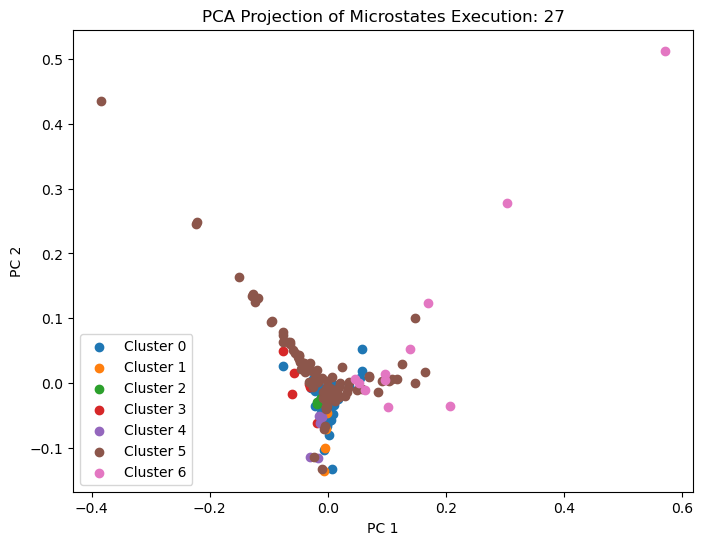

In [51]:
from IPython.display import clear_output
pca_vkin = PCA(n_components = 2)
vkin_reduced = pca_vkin.fit_transform(vkin)

for indExc in range(n_executions):
    clear_output(wait = True)
    plt.clf()
    plt.figure(figsize = (8, 6))
    for i in range(n_clusters):
        plt.scatter(vkin_reduced[clusters_vkin[indExc] == i, 0],
                    vkin_reduced[clusters_vkin[indExc] == i, 1], label=f'Cluster {i}')
    plt.legend(loc = 'best')
    plt.title(f'PCA Projection of Microstates Execution: {indExc}')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.pause(0.33)

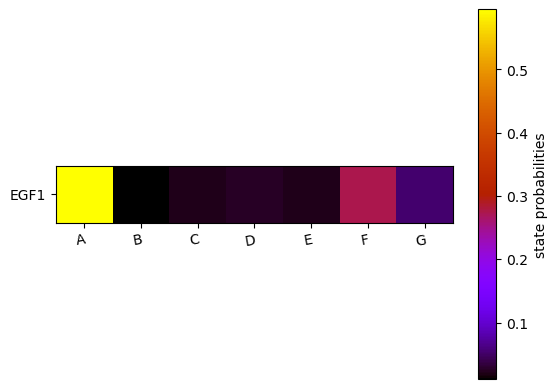

In [53]:
fl = 72
fu = 120
#fu = nframes
stateCenters = clusters_minima.clustercenters
state_probs = np.zeros((num_ligand_conds, n_states))
cell_states = clusters_minima
indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0]

for iEx in range(n_executions):
    
    stateSet = clusters_vkin[iEx]
    n_states = np.unique(stateSet).size
    state_labels = np.array(list(string.ascii_uppercase))[0:n_states]

    for i in range(num_ligand_conds):
         indstm = inds_conditions[i]
         indstwm = np.intersect1d(indstm, indstw)
         #x0 = x[indstwm, :]
         x0 = Xpcat[indstwm, :]
         indc0 = stateSet[clusters_minima.assign(x0)]
         statesc,counts = np.unique(indc0, return_counts=True)
         state_probs[i, statesc] = counts/np.sum(counts)

    state_order = np.arange(n_states).astype(int)
    clear_output(wait = True)
    plt.clf()
    plt.imshow(state_probs[:, state_order], cmap=plt.cm.gnuplot)
    cbar = plt.colorbar()
    cbar.set_label('state probabilities')
    # We want to show all ticks...
    ax = plt.gca()
    ax.set_yticks(np.arange(len(tmSet)))
    ax.set_xticks(np.arange(n_states))
    ax.set_xticklabels(np.array(state_labels)[state_order])
    ax.set_yticklabels(tmSet)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=10, ha="right",rotation_mode="anchor")
    plt.pause(.33);

    #plt.savefig('stProbs_'+figid+'_nS'+str(nstates)+'pc'+str(nPCs)+'u'+str(neigen_umap)+wellsInfo+'.png')
    #np.savetxt('stProbs_'+figid+'_nS'+str(nstates)+'pc'+str(nPCs)+'u'+str(neigen_umap)+wellsInfo+'.dat', state_probs)